## MxNet Installation

In [1]:
!nvidia-smi

Fri Mar  4 09:49:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%%capture
!pip3 install --upgrade mxnet-cu101 gluoncv

In [3]:
import mxnet as mx
from gluoncv.utils import viz
from mxnet.gluon.data import DataLoader
from mxnet.gluon.data.vision import transforms
from mxnet import np
import shutil
import os
import glob

/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.0` and `torch==1.10.0+cu111` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [4]:

from mxnet import np, npx
from mxnet.gluon import nn
npx.set_np()

npx.num_gpus()

1

In [5]:
!wget -nc https://storage.googleapis.com/penn-cis545/dataset_fall_2021.zip -O data.zip
!unzip -q "data.zip"

--2022-03-04 09:50:42--  https://storage.googleapis.com/penn-cis545/dataset_fall_2021.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.219.128, 209.85.146.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.219.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 285578750 (272M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 272.35M   123MB/s    in 2.2s    

2022-03-04 09:50:45 (123 MB/s) - ‘data.zip’ saved [285578750/285578750]



# Section 1: Sports Classification with MxNet
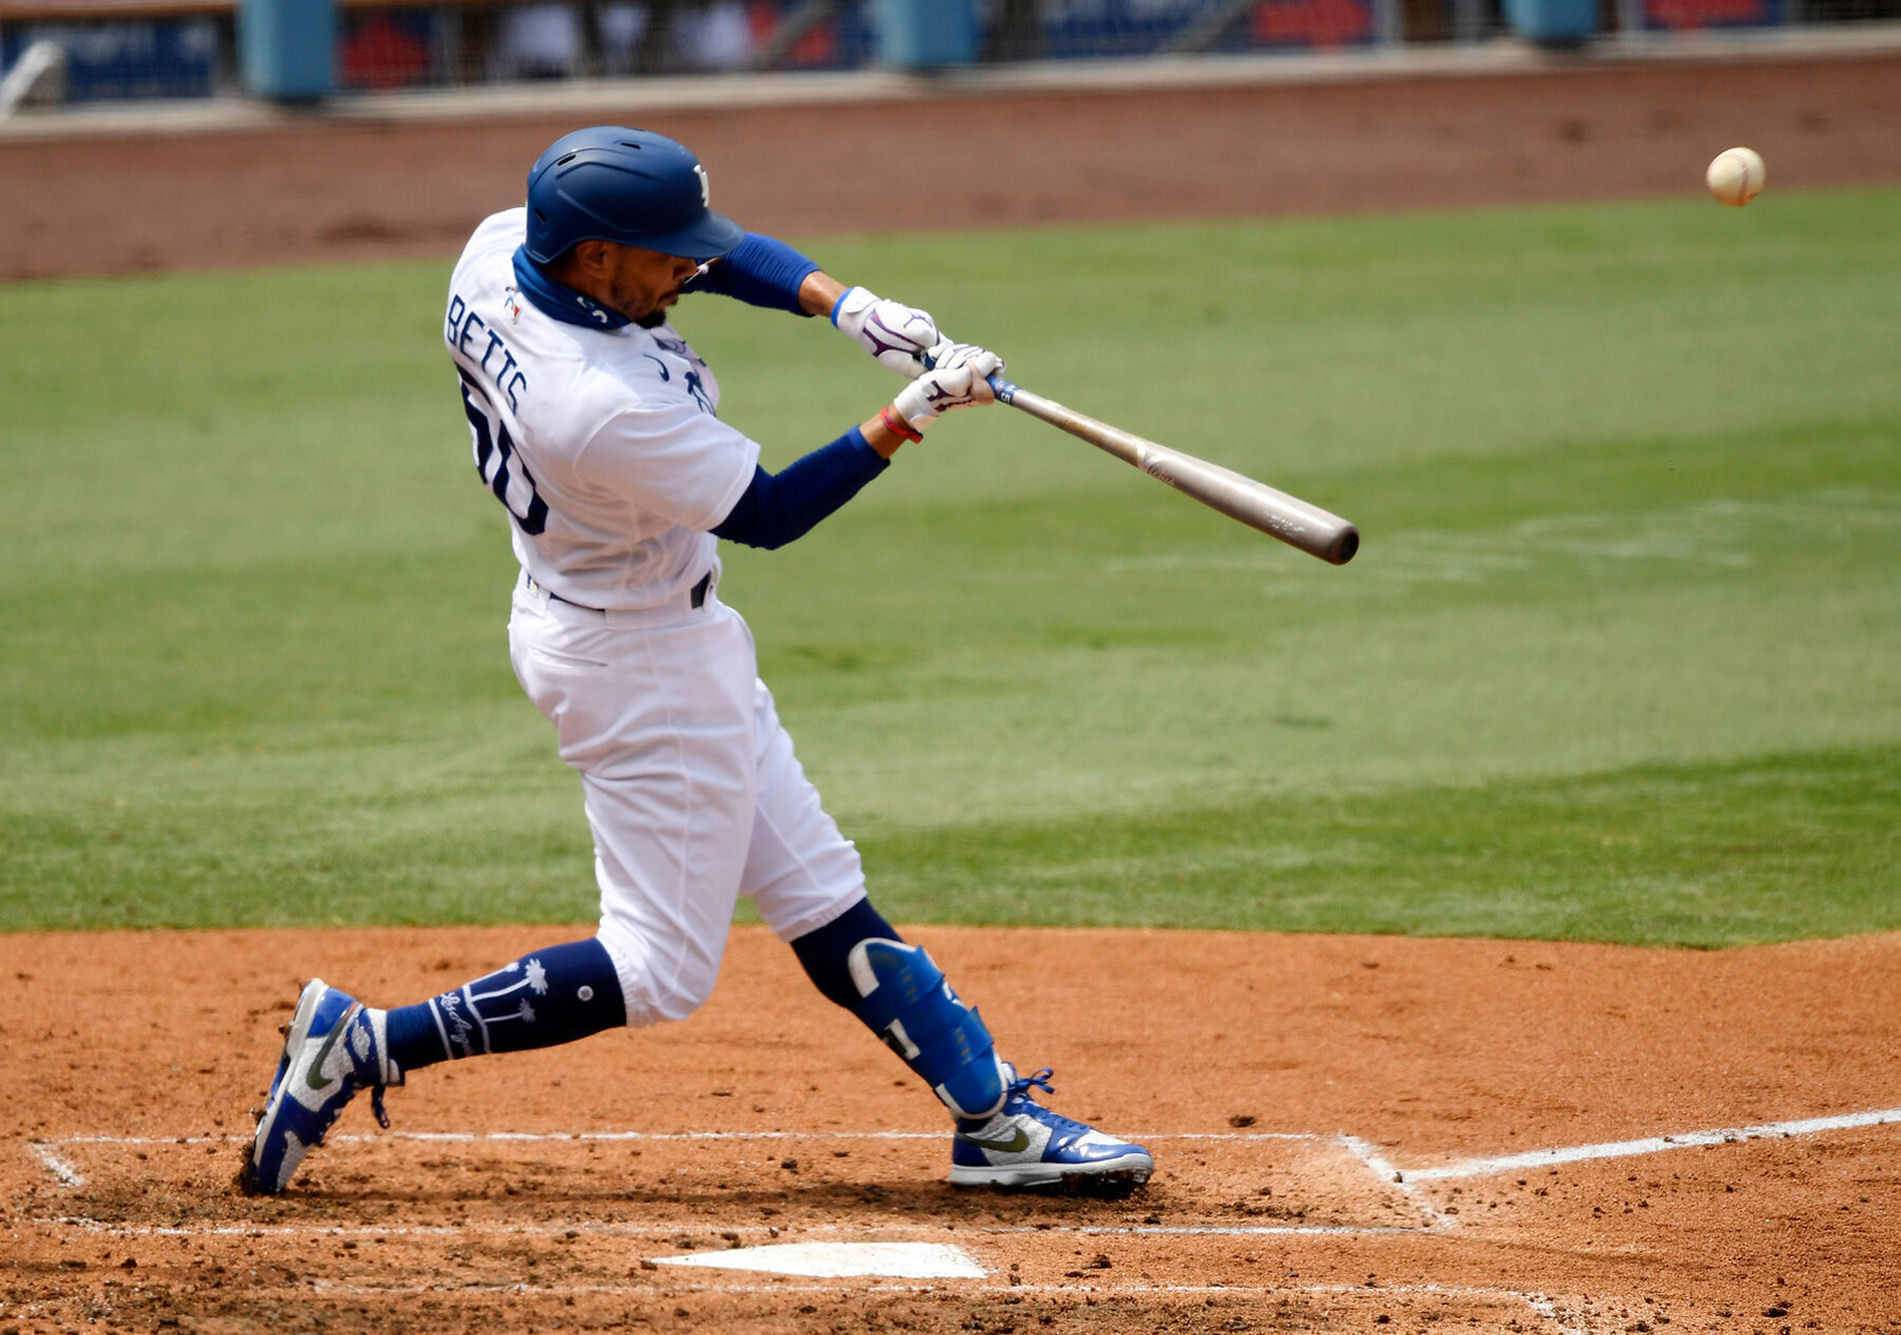

The dataset we'll use is used for the sports classification problem. Multi-class image classification is a challenging problem in computer vision, especially when the number of classes is large. The main difficulty with this specific problem is that while some sports (e.g., football) can be well characterized by global spatial properties, others (e.g., archery) are better characterized by the objects they contain. More generally, to address the sports classification problem, we need a model that can exploit local and global discriminative information.

The dataset contains 73 sports categories. The number of images varies across categories, but there are at least 100 images per category. All images are in jpg format.

## 1.1.1 Filter out corrupt and nonexistent images (5 points)

We have a lot of images in the dataset that aren't valid jpeg images. We need to filter out the invalid images. Complete the check_corrupt function which takes in a filename and returns a boolean indicating if the file is valid.

Additionally, treat any palette images as "corrupt" as well.

Hint: The PIL library would be useful for this! For identifying palette images, check out the attribute `mode` (also related to PIL).




In [6]:
from PIL import Image

def check_corrupt(filename):
  img = Image.open(filename)
  if img.mode == 'P':
    return True
  else:
    try:
      img.verify() 
      return False
    except:
      return True

In [7]:
base_path = '/content/dataset_fall_2021/'
train_path = os.path.join(base_path, 'train/')
test_path = os.path.join(base_path,'test/')

# Check all images in the train file for validity and write the valid ones to train_path
train_paths = glob.glob(os.path.join(train_path, '*/*.jpg'))
test_paths = glob.glob(os.path.join(test_path, '*/*.jpg'))

train_invalid_paths = []
test_invalid_paths = []

correct_file_count_train = 0
for image_path in train_paths:
    if os.path.getsize(image_path) == 0 or check_corrupt(image_path):
      train_invalid_paths.append(image_path)
      continue
    correct_file_count_train += 1

correct_file_count_test = 0
for image_path in test_paths:
    if os.path.getsize(image_path) == 0 or check_corrupt(image_path):
      test_invalid_paths.append(image_path)
      continue
    correct_file_count_test += 1 

print(correct_file_count_train, correct_file_count_test)

10416 365


In [8]:
for path in train_invalid_paths:
  os.remove(path)

for path in test_invalid_paths:
  os.remove(path)

## 1.1.2 Build a dataset class (5 points)

Create train and test datasets for loading image files stored in a folder structure within train_path and test_path. Make sure that the image pixels  are floats in range [0,1] and not integers between [0,255] (Hint: transform parameter)

You should name your datasets train_dataset and test_dataset

Read about how you can do it [here](https://mxnet.apache.org/versions/1.0.0/api/python/gluon/data.html).


In [9]:
#Create train_dataset and test_dataset
train_dataset= mx.gluon.data.vision.ImageFolderDataset(train_path, transform= lambda data, label: (data.astype(np.float32)/255, label))
test_dataset= mx.gluon.data.vision.ImageFolderDataset(test_path, transform= lambda data, label: (data.astype(np.float32)/255, label))

In [10]:
sample_train_img, sample_train_label = train_dataset[5]
sample_test_img, sample_test_label = test_dataset[5]
sample_train_img = sample_train_img.asnumpy()
sample_train_label = sample_train_label
sample_test_img = sample_test_img.asnumpy()
sample_test_label = sample_test_label

## 1.1.3 Visualize images from the dataset

We have our training and testing datasets but we humans don't really understand binary that well. So let's visualize what our data is by plotting some data points

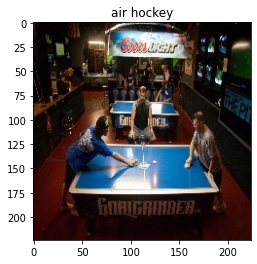

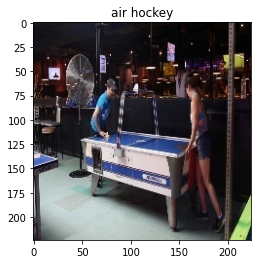

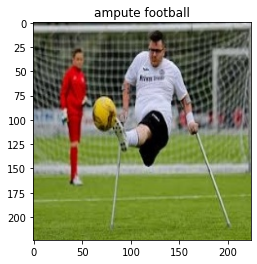

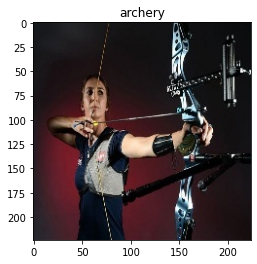

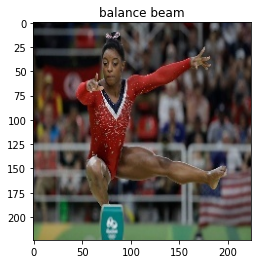

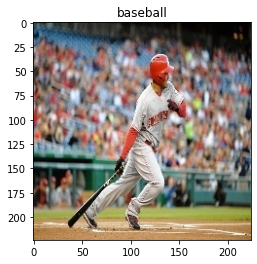

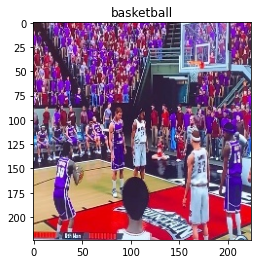

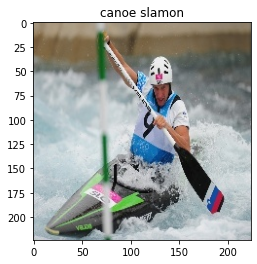

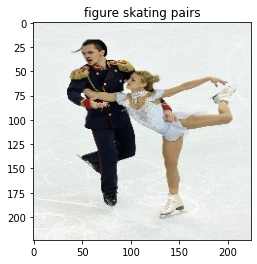

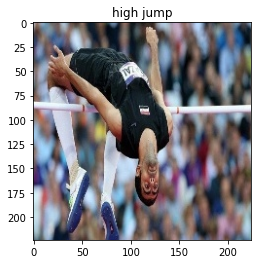

In [11]:
# Visualize 10 images in the dataset with their label
%matplotlib inline

import matplotlib.pyplot as plt

sample_idxs = [1, 3, 213, 224, 567,779,1052,2000, 3000, 4444]
for sample_idx in sample_idxs:
    data, label = train_dataset[sample_idx]
    plt.imshow(data.asnumpy())
    plt.title(train_dataset.synsets[label])
    plt.show()


## 1.1.4 Class frequency distributions
Create a frequency distribution of the classes in the training dataset. You should create a dictionary with the number of faces belonging to each of the emotions. The key for the dictionary should be the name of the scene and the value should be the frequency in the train dataset.

In [12]:
# If I directly use train dataset, the code is following. Otherwise to go with what is asked in function I used this . It gives same output

# def create_frequency_dict(train_dataset_loader, labels):
#   scene_frequency_dict = {}
#   #TODO: Create the scene frequency distribution
#   for stuff in train_dataset:
#     data, lab = stuff
#     if labels[lab] in scene_frequency_dict:
#       scene_frequency_dict[labels[lab]] = scene_frequency_dict[labels[lab]] + 1
#     else:
#       scene_frequency_dict[labels[lab]] = 1
#   return scene_frequency_dict
  

# train_dataset_loader = train_dataset #DataLoader(train_dataset, batch_size=32, num_workers=2) # TODO  
# scene_frequency_dict = create_frequency_dict(train_dataset_loader, train_dataset.synsets)
# print(max(scene_frequency_dict.values()))

In [13]:
def create_frequency_dict(train_dataset_loader, labels):
  scene_frequency_dict = {}
  # Create the scene frequency distribution
  for i, (data, label) in enumerate(train_dataset_loader):
    for lab in label:
      lab=int(lab)
      if labels[lab] in scene_frequency_dict:
        scene_frequency_dict[labels[lab]] = scene_frequency_dict[labels[lab]] + 1
      else:
        scene_frequency_dict[labels[lab]] = 1
  return scene_frequency_dict
  

train_dataset_loader = DataLoader(train_dataset, batch_size=32, num_workers=2) # TODO  
scene_frequency_dict = create_frequency_dict(train_dataset_loader, train_dataset.synsets)
print(max(scene_frequency_dict.values()))

191


Does the class distribution look uniform? If yes, we don't need to address class imbalance, if no, what should we do?

## 1.1.5 Create Dataloader objects (5 points)


Data loaders create data batches and perform transformations on the images. 

Since the images are different sizes, we need to resize them to the same value. You should write a transformation to resize the image to 224 x 224. You would also need to add a transformation to convert the image to a tensor - building blocks of neural network operations. Tensors are like numpy arrays with a gradient aspect. 

TLDR, in this section you will need to
 
*   Define a composition of transformations to first resize the image and then convert to tensors
*   Next create train and test data loaders, apply the transformations to the train and test datasets respectively. You will also need to pass in the batch size and whether or not you want to shuffle the data. 
*   Set shuffle = True for the train and False for the test set.
*   Use a batch size of 32 for the train loader and a batch size of 1 for the test set.

[Refer](https://mxnet.apache.org/api/python/docs/api/gluon/data/vision/transforms/index.html#mxnet.gluon.data.vision.transforms.Compose) to the transformation documentation


In [14]:
from mxnet.gluon.data import DataLoader

# Define the transformation and the train and test loaders
resizer= mx.gluon.data.vision.transforms.Resize(size=(224,224))
to_tensor = mx.gluon.data.vision.transforms.ToTensor()

train_dataset = train_dataset.transform_first(resizer)
train_dataset = train_dataset.transform_first(to_tensor)

test_dataset = test_dataset.transform_first(resizer)
test_dataset = test_dataset.transform_first(to_tensor)

train_loader= DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader= DataLoader(test_dataset, batch_size=1, shuffle=False)

In [15]:
answer = None
for data, label in train_loader:
    answer = data.asnumpy().shape, label.asnumpy().shape
    break

answer2 = None
for data, label in test_loader:
    answer2 = data.asnumpy(), label.asnumpy()
    break

# Section 2: Let's build classifiers!

We have the data we need to train a scene classifier. We will start simple with a logistic regression classifier as a baseline for our performance before we move onto more complex neural networks. 

## 2.1.1 Logical Logistic Regression - Baseline (20 points)

 Let's first try solving this problem with a Logistic Regression classifier solving the multiclass classification problem.

We will define a logistic regression model in Apache MxNet and train it on our training set and evaluate the performance on the test set

### Model Definition

We will define our first model in mxnet. Read up about gluon and autograd modules and how to use them to create layers in a neural network.

Our first model is a logistic regression model with the number of outputs equal to the number of classes in the model. Complete the construct net function with the logistic regression model definition

In [16]:
from mxnet import gluon, autograd, ndarray

def construct_net():
    net = gluon.nn.HybridSequential() # TODO: Initialize a gluon sequential model
    with net.name_scope():
      net.add(gluon.nn.Dense(units=73))
        # Add a gluon dense layer to the model
    return net

net = construct_net()

# Set the context to use the available GPUs, otherwise just use a CPU
ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu()

Now we need to initialize the model weights and the context, call the net initialize function with Xavier Initialization (sets your starting model weights, read more about it online if you are curious) also set the ctx variable with the context defined above

In [17]:
net.initialize(mx.init.Xavier(), ctx=ctx)

Let's print the model summary

In [18]:
x = mx.sym.var('data').as_np_ndarray()
sym = net(x)
mx.viz.print_summary(sym)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                                                  0                                           
________________________________________________________________________________________________________________________
hybridsequential0_dense0_fwd(FullyConnected)                                73          data                            
Total params: 73
________________________________________________________________________________________________________________________


In [19]:
x = net(mx.nd.random.uniform(shape=(32, 3, 224, 224), ctx=ctx).as_np_ndarray())

This is a multi-class classification problem, so we will use the *categorical cross-entropy* loss function. It is defined as:

$$L(y,\hat y)=-\sum_{j=0}^M\sum_{i=0}^{N}(y_{ij} log(\hat y_{ij}))$$

Luckily, we don't have to write it ourselves, we will use the implementation within Mxnet and Gluon.

Let's first define our criterion i.e. the loss function we want to optimize for.

Read more about gluon loss functions [here](https://mxnet.apache.org/api/python/docs/api/gluon/loss/index.html).

In [20]:
# Define a gluon Softmax Cross Entropy object, name this 'criterion', 
# the softmax indicates that the loss function does a softmax first to get the probabilities
# and then computes the Cross EntropyLoss
criterion = gluon.loss.SoftmaxCrossEntropyLoss() #TODO

Next, we define a trainer object, which includes an optimizer - we will use a stochastic gradient descent optimizer to optimize for our criterion and update our weights. 
We need 3 parameters while defining a gluon optimizer. 


1.   Trainable parameters in the model - net.collect_params() gives you all these parameters
2.   An optimizer - 'sgd' or 'adam', for this task, use the adaptive moment estimation algorithm aka 'adam'
3.   Optimizer params - A dictionary with parameters for your optimizer. We only need to specify the learning rate parameter within this dictionary.

The learning rate is a hyperparameter that you should train for. You should start with a small learning rate like 0.001.

Read more about the trainer object [here](https://mxnet.apache.org/api/python/docs/api/gluon/trainer.html).




In [21]:
trainer = gluon.Trainer(params=net.collect_params(), optimizer= 'adam', optimizer_params={'learning_rate':0.001})

### Train Model

Next, we need to iterate through our training data multiple times to optimize our weights. Each of the iterations is called an epoch. 

We will write a training loop now. Here is the pseudocode for the training loop: 

1. Define an [accuracy metric ](https://mxnet.apache.org/api/python/docs/api/metric/index.html) to measure performance.
1.   Repeat the following for a number of epochs
2.   Iterate through the mini batches in the training dataloader
3.   Each minibatch object will be a tuple (data, labels)
4.   Each minibatch has a number of images and a number of labels (batch size number of images and labels in each minibatch). Thus each data object will be of the shape (BATCH_SIZE, 3, 224, 224). The 3 corresponds to the number of channels - RGB and the labels array would be of size (BATCH_SIZE)
5.   Since our model requires linear inputs and not multiple channels, flatten the image in the batch. The reshape function will help you to do this.
6.   Send the data and label to the GPU. The 'as_in_context' with the ctx defined above will help you to do this.
7.   Compute the model outputs for the flattened data using the net object defined above
8.   Compute the loss function with criterion we previously defined
9.   Compute the accuracy using the metric object defined above.
10.  Backpropogate through the computed loss value. This would compute the gradients for each of the model parameters.
11.  Use a trainer to perform an optimizer step - this updates the weights based on the computed gradients with repect to the loss function.
12.  To see how your accuracy improves and the loss decreases, after each epoch print out the accuracy and the loss for that epoch. 


You should also plot your training accuracies and training loss function vs epochs. The plot is worth 5 points!


Train your logistic regression model for 10 epochs.

In [ ]:
from mxnet import gluon, autograd, ndarray


#Define a training function which trains the passed network for the given number of epochs using the provided optimizer and criterion
# The function should return the final training loss and the final training accuracy
def train_network(net, train_loader, criterion, trainer, metric, epochs = 10):
    #Define your training loop here
    accuracy_graph=[]
    loss_graph=[]
    epoch_graph=[]
    for epoch in range(epochs):
      epoch_graph.append(epoch+1)
      total_loss = 0
      total=0
      for i, (data, label) in enumerate(train_loader):
        total= total+1
        data=data.reshape(-1, 3*224, 224)
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
              output = net(data)
              loss = criterion(output, label)
              metric.update(labels= label, preds=np.argmax(output, axis=1))
        loss.backward()
        trainer.step(label.shape[0])
        accuracy=metric.get()[1]
        total_loss= total_loss+ np.mean(loss)
      accuracy_graph.append(accuracy)
      loss=total_loss/total
      loss_graph.append(loss)
      print("Epoch: ", epoch+1, ", Accuracy: ", accuracy, ", Loss: ", loss)
    final_training_accuracy = accuracy   #Set this to final training accuracy
    final_training_loss = loss           #Set this to final testing accuracy
    return float(final_training_loss), float(final_training_accuracy), accuracy_graph, loss_graph, epoch_graph 

epochs = 10
metric = mx.metric.Accuracy() #Define an accuracy metric
lr_training_loss,lr_training_accuracy, accuracy_graph, loss_graph, epoch_graph  = train_network(net, train_loader, criterion, trainer, metric, epochs)

print("Logistic Regression - the training loss is ", str(lr_training_loss))
print("Logistic Regression - the training accuracy is ", str(lr_training_accuracy))

Epoch:  1 , Accuracy:  0.06288402457757296 , Loss:  4.0656157
Epoch:  2 , Accuracy:  0.10229454685099847 , Loss:  3.6825154
Epoch:  3 , Accuracy:  0.12832821300563235 , Loss:  3.4836242
Epoch:  4 , Accuracy:  0.1518337173579109 , Loss:  3.3312745
Epoch:  5 , Accuracy:  0.17104454685099846 , Loss:  3.2169254
Epoch:  6 , Accuracy:  0.1878520225294419 , Loss:  3.1206853
Epoch:  7 , Accuracy:  0.20276497695852536 , Loss:  3.0332453
Epoch:  8 , Accuracy:  0.21608582949308755 , Loss:  2.9551988
Epoch:  9 , Accuracy:  0.2287826420890937 , Loss:  2.8881693
Epoch:  10 , Accuracy:  0.24050499231950845 , Loss:  2.826676
Logistic Regression - the training loss is  2.8266758918762207
Logistic Regression - the training accuracy is  0.24050499231950845


Is your model learning? Is the loss decreasing? Is it able to classifiy better after training?




In [ ]:
import matplotlib.pyplot as plt

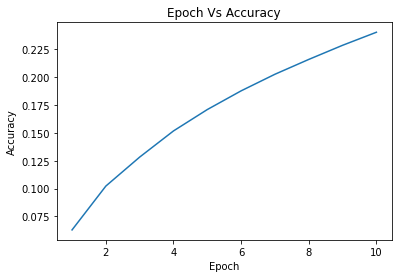

In [ ]:
# Training Accuracy vs Epochs
plt.plot(epoch_graph,accuracy_graph)
plt.title("Epoch Vs Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

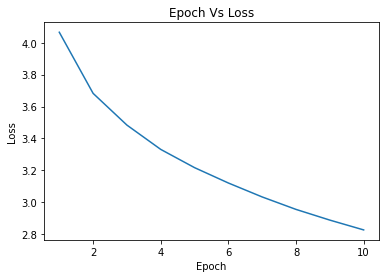

In [ ]:
# Training Accuracy vs Epochs
plt.plot(epoch_graph, loss_graph)
plt.title("Epoch Vs Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Evaluate Model

Evaluate the model performance on the test set. Compute the cross entropy loss and accuracy on the test set.

Note:  Please don't report false numbers for the accuracy as we will be reviewing these manually and if if there is a manipulation with the accuracy computation, you will get a 0 for the entire section.


In [ ]:
def test_model(net, criterion, test_loader, metric):
    total=0
    total_loss=0
    for i, (data, label) in enumerate(test_loader):
      data=data.reshape(-1, 3*224, 224)
      data = data.as_in_context(ctx)
      label = label.as_in_context(ctx)
      output = net(data)
      loss= criterion(output, label)
      metric.update(labels= label, preds=np.argmax(output, axis=1))
      total=total+1
      total_loss= total_loss+ np.mean(loss)
    accuracy=metric.get()[1]
    testing_accuracy=accuracy
    testing_loss=total_loss/total
    return  float(testing_loss), float(testing_accuracy)

# Define an accuracy metric
lr_testing_loss, lr_testing_accuracy = test_model(net, criterion, test_loader, metric)

print("Logistic Regression - the testing loss is ", str(lr_testing_loss))
print("Logistic Regression - the testing accuracy is ", str(lr_testing_accuracy))

Logistic Regression - the testing loss is  3.178960084915161
Logistic Regression - the testing accuracy is  0.2405548911743602


Does the logistic regression fit well to the data? Think about whether this is underfitting or overfitting? Think about if we need more representational power or we need more regularization to make it better?

## 2.1.2 Feedforward Neural Networks (20 points)

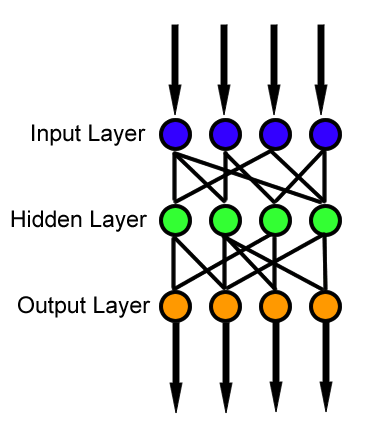

Since logistic regression isn't that great at fitting our classification problem, we need more representation power. We will now define a feedforward neural network


Complete the `create_ff_net` function below to define a feedforward neural network with at least 2 hidden layers. Note that the last layer must have the number of classes as the output size! You will also need to initialize the network, create a new `trainer` object with the parameters of the feedforward network. Use a ReLU activation function for the hidden layers. 


In [ ]:
from mxnet import gluon, autograd, ndarray

def construct_ff_net():
    ff_net = gluon.nn.HybridSequential()
    # Create a feedforward network, experiment with the number of hidden layers and the number of sizes of the hidden layers
    with ff_net.name_scope():
      ff_net.add(gluon.nn.Dense(units=256, activation='relu'))
      ff_net.add(gluon.nn.Dense(units=128, activation='relu'))
      ff_net.add(gluon.nn.Dense(units=64, activation='relu'))
      ff_net.add(gluon.nn.Dense(units=73))
    return ff_net

ff_net  = construct_ff_net()
#Initialize the network
ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu()
ff_net.initialize(mx.init.Xavier(), ctx=ctx)
metric_ffn = mx.metric.Accuracy() 
criterion_ffn = gluon.loss.SoftmaxCrossEntropyLoss() 
trainer_ffn = gluon.Trainer(params=ff_net.collect_params(), optimizer= 'adam', optimizer_params={'learning_rate':0.001}) #TODO: Create a new trainer object for this network

Print the model summary for the fully connected network.

In [ ]:
x = mx.sym.var('data')
sym = ff_net(x.as_np_ndarray())
mx.viz.print_summary(sym)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                                                  0                                           
________________________________________________________________________________________________________________________
hybridsequential1_dense0_fwd(FullyConnected)                                256         data                            
________________________________________________________________________________________________________________________
hybridsequential1_dense0_relu_fwd(Activation)                               0           hybridsequential1_dense0_fwd    
________________________________________________________________________________________________________________________
hybridsequential1_dense1_fwd(Ful

Now train this network using the train network function defined above. Create plots for the training accuracy and training loss vs the number of epochs.


In [ ]:
#Train the feedforward neural network on the training set using the train_network function
epochs_ffn = 10
ffn_training_loss,ffn_training_accuracy, ffn_accuracy_graph, ffn_loss_graph, ffn_epoch_graph  = train_network(ff_net, train_loader, criterion_ffn, trainer_ffn, metric_ffn, epochs_ffn)

Epoch:  1 , Accuracy:  0.03389016897081413 , Loss:  4.130625
Epoch:  2 , Accuracy:  0.057987711213517666 , Loss:  3.716983
Epoch:  3 , Accuracy:  0.07520481310803892 , Loss:  3.515679
Epoch:  4 , Accuracy:  0.09144585253456221 , Loss:  3.3585427
Epoch:  5 , Accuracy:  0.10616359447004609 , Loss:  3.2397757
Epoch:  6 , Accuracy:  0.1194636456733231 , Loss:  3.130633
Epoch:  7 , Accuracy:  0.13198101821373712 , Loss:  3.033696
Epoch:  8 , Accuracy:  0.14357718894009217 , Loss:  2.9459877
Epoch:  9 , Accuracy:  0.15443121693121692 , Loss:  2.8591726
Epoch:  10 , Accuracy:  0.1650825652841782 , Loss:  2.7929678


In [ ]:
#plot curves

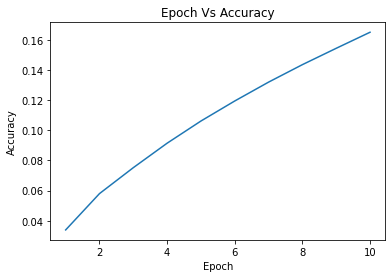

In [ ]:
# Training Accuracy vs Epochs
plt.plot(ffn_epoch_graph,ffn_accuracy_graph)
plt.title("Epoch Vs Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

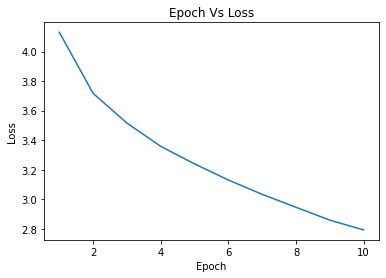

In [ ]:
# Training Accuracy vs Epochs
plt.plot(ffn_epoch_graph, ffn_loss_graph)
plt.title("Epoch Vs Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Once again, evaluate the model performance on the test set. Compute the cross entropy loss and accuracy on the test set

In [ ]:
# Compute performance on the test set using the test_network function created before
ffn_testing_loss, ffn_testing_accuracy =test_model(ff_net, criterion_ffn, test_loader, metric_ffn)

Does the feedforward network do better than logistic regression? Play around with the network architecture to see how it affects the performance on both the train and test data.

## 2.1.3 Convoluted Convolutional Neural Networks (25 points)
**So, what are CNNs?**

Convolutional Neural Networks are very similar to Feedforward Neural Networks from the previous section: they are made up of neurons that have learnable weights and biases. Each neuron receives some inputs, performs a dot product and optionally follows it with a non-linearity. The whole network still expresses a single differentiable score function: from the raw image pixels on one end to class scores at the other. 

So what changes? ConvNet architectures make the explicit assumption that the inputs are images, which allows us to encode certain properties into the architecture. These then make the forward function more efficient to implement and vastly reduce the amount of parameters in the network.

If you wanna know more about how CNNs function and see some cool visualizations, we would highly recommend [this](http://cs231n.github.io/convolutional-networks/) page


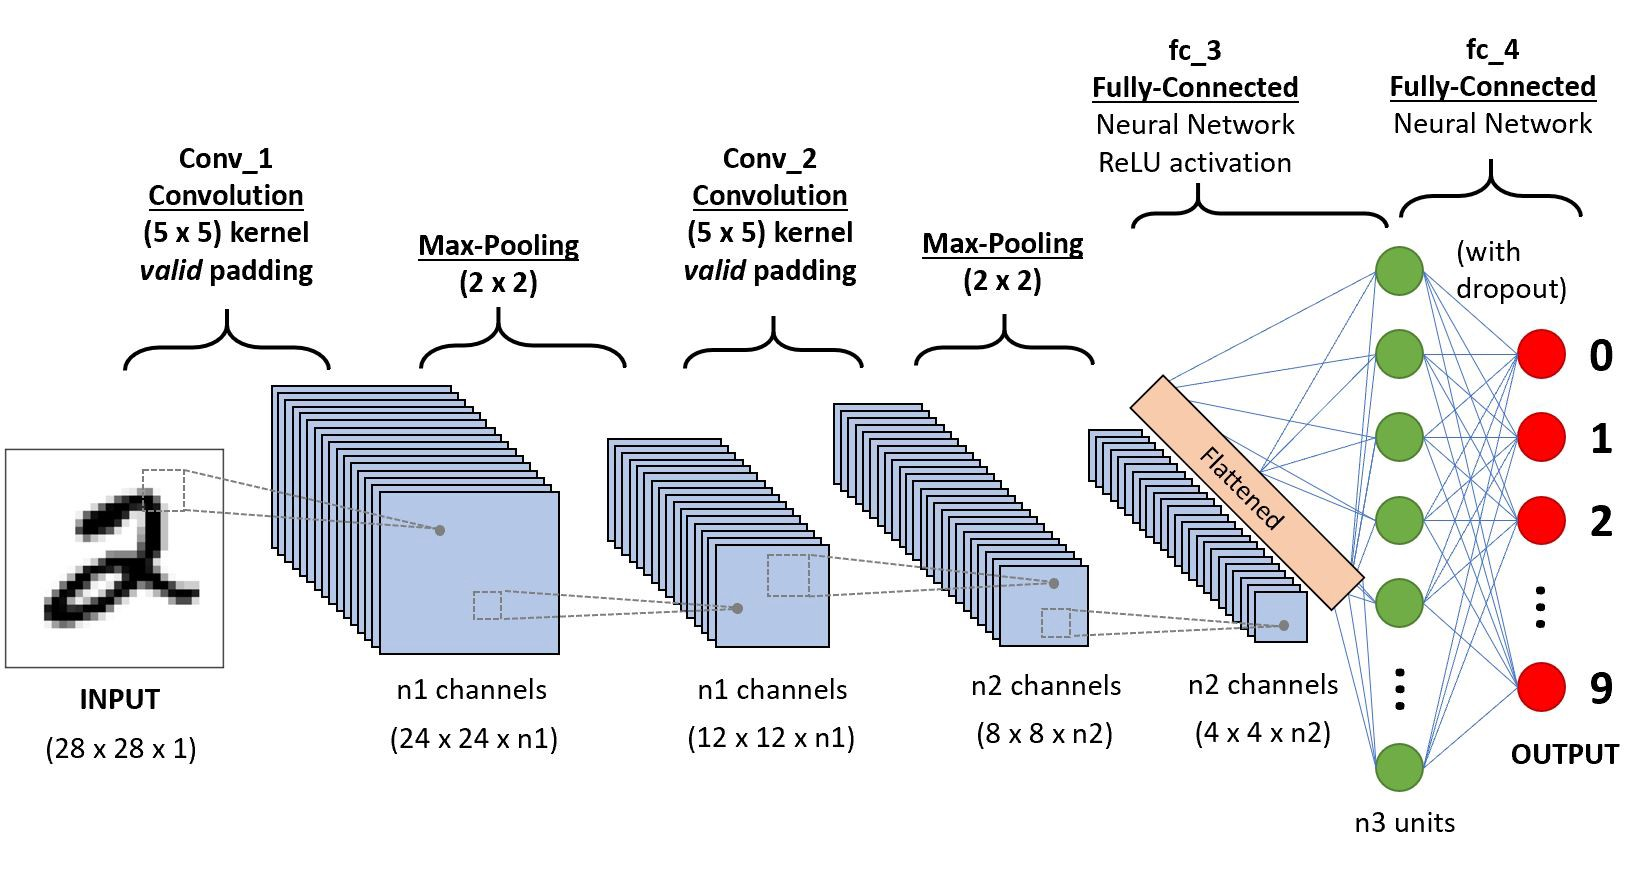


We will define the architecture for the CNN we will be using. The components of CNNs are: 


*   Convolutional Layers
*   Pooling Layers
*   Linear Layers
*   Activation Functions

Define a CNN model with Mxnet and Gluon with a convolutional layer followed by an activation function and a max pool, for one or more layers; then flatten the output from the convolutional layers and pass it through one or more fully connected or 'dense' layers and activation functions after all but the last layer. Note that the output shape from the last layer must be the same as the number of classes.

You can find some examples of this here: https://gluon.mxnet.io/chapter03_deep-neural-networks/mlp-gluon.html#Faster-modeling-with-gluon.nn.Sequential

In [ ]:
import mxnet.ndarray as F

def construct_conv_net():
    cnn = gluon.nn.Sequential()
    # Create a feedforward network, experiment with the number of hidden layers and the number of sizes of the hidden layers
    with cnn.name_scope():
      cnn.add(gluon.nn.Conv2D(channels=64, kernel_size=8, activation='relu'))
      cnn.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
      cnn.add(gluon.nn.Flatten())
      cnn.add(gluon.nn.Dense(128, activation="relu"))
      cnn.add(gluon.nn.Dense(units=73))
    return cnn

cnn  = construct_conv_net()

Once again, we ask you to create a network, initialize it and create a trainer for it.

In [ ]:
# Initialize network, initialize the criterion and the trainer
ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu()
cnn.initialize(mx.init.Xavier(), ctx=ctx)
metric_conv = mx.metric.Accuracy() 
criterion_conv = gluon.loss.SoftmaxCrossEntropyLoss() 
trainer_conv = gluon.Trainer(params=cnn.collect_params(), optimizer= 'adam', optimizer_params={'learning_rate':0.001})

In [ ]:
x = mx.sym.var('data')
sym = cnn(x.as_np_ndarray())
mx.viz.print_summary(sym)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                                                  0                                           
________________________________________________________________________________________________________________________
sequential0_conv0_fwd(Convolution)                                          64          data                            
________________________________________________________________________________________________________________________
sequential0_conv0_relu_fwd(Activation)                                      0           sequential0_conv0_fwd           
________________________________________________________________________________________________________________________
sequential0_pool0_fwd(Pooling)  

Write another function to train a convolutional neural network on the train data given the network, trainer and criterion. Train the CNN for 25 epochs. Plot the training loss and accuracy curves.

Note that there will be a slight difference from training a feedforward network cause here you will the image information in separate channels as the input, rather than a single flattened input.

In [ ]:
from mxnet import gluon, autograd, ndarray

# Define a training function which trains the passed network for the given number of epochs using the provided optimizer and criterion
# The function should return the final training loss and the final training accuracy
def train_cnn(net, train_loader, criterion, trainer, metric, epochs):
  # Define your training loop here
  accuracy_graph=[]
  loss_graph=[]
  epoch_graph=[]
  for epoch in range(epochs):
    epoch_graph.append(epoch+1)
    total_loss = 0
    total=0
    for i, (data, label) in enumerate(train_loader):
      total= total+1
      data = data.as_in_context(ctx)
      label = label.as_in_context(ctx)
      with autograd.record():
        output = net(data)
        loss = criterion(output, label)
        metric.update(labels= label, preds=np.argmax(output, axis=1))
      loss.backward()
      trainer.step(label.shape[0])
      accuracy=metric.get()[1]
      total_loss= total_loss+ np.mean(loss)
    accuracy_graph.append(accuracy)
    loss=total_loss/total
    loss_graph.append(loss)
    print("Epoch: ", epoch+1, ", Accuracy: ", accuracy, ", Loss: ", loss)
  final_training_accuracy = accuracy   # Set this to final training accuracy
  final_training_loss = loss           #Set this to final testing accuracy
  return float(final_training_loss), float(final_training_accuracy), accuracy_graph, loss_graph, epoch_graph 

cnn_training_loss, cnn_training_accuracy, conv_accuracy_graph, conv_loss_graph, conv_epoch_graph = train_cnn(cnn, train_loader, criterion_conv, trainer_conv, metric_conv, 25)

Epoch:  1 , Accuracy:  0.036290322580645164 , Loss:  4.1376543
Epoch:  2 , Accuracy:  0.05885176651305683 , Loss:  3.8632512
Epoch:  3 , Accuracy:  0.0745647721454173 , Loss:  3.7198071
Epoch:  4 , Accuracy:  0.0883976574500768 , Loss:  3.5990753
Epoch:  5 , Accuracy:  0.1005568356374808 , Loss:  3.5004241
Epoch:  6 , Accuracy:  0.1111111111111111 , Loss:  3.4113817
Epoch:  7 , Accuracy:  0.12044656572306342 , Loss:  3.340703
Epoch:  8 , Accuracy:  0.1298963133640553 , Loss:  3.263631
Epoch:  9 , Accuracy:  0.13921957671957672 , Loss:  3.1849024
Epoch:  10 , Accuracy:  0.14820468509984638 , Loss:  3.1108518
Epoch:  11 , Accuracy:  0.15729297584136293 , Loss:  3.0389686
Epoch:  12 , Accuracy:  0.1660186251920123 , Loss:  2.963121
Epoch:  13 , Accuracy:  0.17479026349994092 , Loss:  2.886062
Epoch:  14 , Accuracy:  0.1835637480798771 , Loss:  2.8114157
Epoch:  15 , Accuracy:  0.1919098822324629 , Loss:  2.7326932
Epoch:  16 , Accuracy:  0.20010680683563747 , Loss:  2.6597826
Epoch:  17 ,

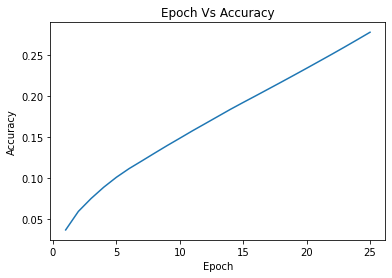

In [ ]:
# Training Accuracy vs Epochs
plt.plot(conv_epoch_graph,conv_accuracy_graph)
plt.title("Epoch Vs Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

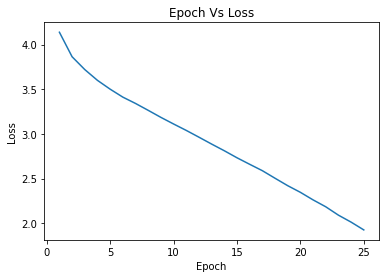

In [ ]:
# Training Accuracy vs Epochs
plt.plot(conv_epoch_graph, conv_loss_graph)
plt.title("Epoch Vs Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Once again, evaluate the model performance on the test set. Compute the cross entropy loss and accuracy on the test set

In [ ]:
def test_model(net, criterion, test_loader, metric):
    total=0
    total_loss=0
    for i, (data, label) in enumerate(test_loader):
      data = data.as_in_context(ctx)
      label = label.as_in_context(ctx)
      output = net(data)
      loss= criterion(output, label)
      metric.update(labels= label, preds=np.argmax(output, axis=1))
      total=total+1
      total_loss= total_loss+ np.mean(loss)
    accuracy=metric.get()[1]
    testing_accuracy=accuracy
    testing_loss=total_loss/total
    return  float(testing_loss), float(testing_accuracy)

In [ ]:
# Compute performance on the test set, you may need to write a new function modifying test_network without the flattening aspect
cnn_testing_accuracy, cnn_testing_loss = test_model(cnn, criterion_conv, test_loader, metric_conv)

# CNN has 265 parameters and FFN had 521 parameters, between the two the CNN worked better, but that may be because of more epochs. But CNN with half as many parameters did quite well and ended up with a better accuracy in the end